# M10 Model: AD vs HC 预测模型

## 策略
- **训练集**: GSE140829 + ADNI (757 样本)
- **验证方式**: 5-fold CV + Leave-One-Group-Out CV
- **外部测试**: qPCR (22 样本, 仅Z-score归一化)
- **特征选择**: 搜索最优基因子集

In [1]:
# Cell 1: 导入库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
from itertools import combinations

from sklearn.model_selection import StratifiedKFold, cross_val_predict, LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, accuracy_score, recall_score, 
                             confusion_matrix, roc_curve)

warnings.filterwarnings('ignore')
np.random.seed(42)
plt.rcParams['font.size'] = 11

OUTPUT_DIR = Path('./4_m10_model')
OUTPUT_DIR.mkdir(exist_ok=True)
print("Libraries loaded!")

Libraries loaded!


In [ ]:
# Cell 2: 加载数据
DATA_DIR = Path('./0_rawdata')

# M10 候选基因
M10_GENES = ['NAGK', 'PAK1', 'PRR13', 'QPCT', 'SLC22A4', 
             'ARHGAP17', 'BTK', 'RYBP', 'TAGLN', 'TMEM154']

# 加载数据
exp_df = pd.read_csv(DATA_DIR / 'exp_mono.csv', index_col=0)
ph_df = pd.read_csv(DATA_DIR / 'ph_mono.csv', index_col=0)
test_df = pd.read_csv(DATA_DIR / 'testset2.csv', index_col=0)

# qPCR 数据 (仅 Z-score，不做 log2 转换)
test_df_processed = test_df  # 直接使用原始数据，后续会做 Z-score

# 准备训练数据
ph_indexed = ph_df.set_index('id')
all_samples = [s for s in exp_df.columns if s in ph_indexed.index]

y_train = np.array([1 if ph_indexed.loc[s, 'group'] == 'AD' else 0 for s in all_samples])
groups = np.array([ph_indexed.loc[s, 'gse'] for s in all_samples])

# 准备测试数据
y_test = np.array([0 if 'HC' in s else 1 for s in test_df_processed.columns])

print("【数据概览】")
print(f"训练: {len(all_samples)} 样本 (AD={sum(y_train)}, HC={len(y_train)-sum(y_train)})")
print(f"  - GSE140829: {sum(groups=='GSE140829')} 样本")
print(f"  - ADNI: {sum(groups=='ADNI')} 样本")
print(f"测试: {len(y_test)} 样本 (AD={sum(y_test)}, HC={len(y_test)-sum(y_test)})")

【数据概览】
训练: 757 样本 (AD=248, HC=509)
  - GSE140829: 453 样本
  - ADNI: 304 样本
测试: 22 样本 (AD=11, HC=11)


In [3]:
# Cell 3: 基因组合搜索函数
def evaluate_genes(genes):
    """评估基因组合"""
    X_train = exp_df.loc[genes, all_samples].T
    X_test = test_df_processed.loc[genes].T
    
    # 标准化 (各自独立)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = StandardScaler().fit_transform(X_test)
    
    model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
    
    # 5-fold CV
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_cv = cross_val_predict(model, X_train_s, y_train, cv=cv, method='predict_proba')[:, 1]
    cv_auc = roc_auc_score(y_train, y_cv)
    
    # Leave-One-Group-Out CV
    logo = LeaveOneGroupOut()
    y_logo = cross_val_predict(model, X_train_s, y_train, cv=logo, groups=groups, method='predict_proba')[:, 1]
    logo_auc = roc_auc_score(y_train, y_logo)
    
    # 完整训练
    model.fit(X_train_s, y_train)
    
    # 测试
    y_pred = model.predict_proba(X_test_s)[:, 1]
    test_auc = roc_auc_score(y_test, y_pred)
    test_acc = accuracy_score(y_test, (y_pred >= 0.5).astype(int))
    test_sens = recall_score(y_test, (y_pred >= 0.5).astype(int))
    test_spec = recall_score(y_test, (y_pred >= 0.5).astype(int), pos_label=0)
    
    # 综合评分
    score = logo_auc * 0.4 + cv_auc * 0.2 + test_auc * 0.4
    
    return {
        'genes': genes, 'n_genes': len(genes),
        'cv_auc': cv_auc, 'logo_auc': logo_auc,
        'test_auc': test_auc, 'test_acc': test_acc,
        'test_sens': test_sens, 'test_spec': test_spec,
        'score': score, 'model': model
    }

In [4]:
# Cell 4: 搜索最优基因组合
print("【搜索最优基因组合】")
print(f"{'基因数':>6} {'5-CV':>7} {'LOGO':>7} {'Test AUC':>9} {'Test Acc':>9} {'组合'}")
print("-" * 75)

best_results = []
for n in range(3, 8):
    best_for_n = None
    for combo in combinations(M10_GENES, n):
        result = evaluate_genes(list(combo))
        if best_for_n is None or result['score'] > best_for_n['score']:
            best_for_n = result
    best_results.append(best_for_n)
    print(f"{n:>6} {best_for_n['cv_auc']:>7.4f} {best_for_n['logo_auc']:>7.4f} "
          f"{best_for_n['test_auc']:>9.4f} {best_for_n['test_acc']:>9.4f} {', '.join(best_for_n['genes'])}")

# 选择最优
OPTIMAL = max(best_results, key=lambda x: x['score'])
OPTIMAL_GENES = OPTIMAL['genes']
print(f"\n最优: {len(OPTIMAL_GENES)} 基因 - {', '.join(OPTIMAL_GENES)}")

【搜索最优基因组合】
   基因数    5-CV    LOGO  Test AUC  Test Acc 组合
---------------------------------------------------------------------------
     3  0.6638  0.6529    1.0000    0.8636 NAGK, QPCT, RYBP
     4  0.6740  0.6481    1.0000    0.9545 NAGK, QPCT, RYBP, TAGLN
     5  0.6767  0.6597    1.0000    0.9091 NAGK, QPCT, ARHGAP17, RYBP, TAGLN
     6  0.6959  0.6644    0.9917    0.9091 NAGK, PAK1, QPCT, ARHGAP17, TAGLN, TMEM154
     7  0.6945  0.6673    1.0000    0.9545 NAGK, PAK1, QPCT, ARHGAP17, RYBP, TAGLN, TMEM154

最优: 7 基因 - NAGK, PAK1, QPCT, ARHGAP17, RYBP, TAGLN, TMEM154


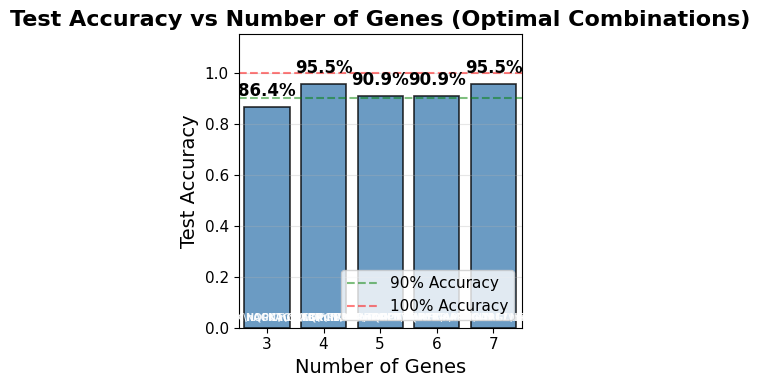

图片已保存: 4_m10_model/gene_combination_accuracy.pdf


In [ ]:
# Cell 4.5: 绘制不同基因数的准确率变化图
n_genes_list = [r['n_genes'] for r in best_results]
test_acc_list = [r['test_acc'] for r in best_results]
best_genes_list = [r['genes'] for r in best_results]

fig, ax = plt.subplots(figsize=(5, 4))

# 柱状图
bars = ax.bar(n_genes_list, test_acc_list, color='steelblue', alpha=0.8, 
              edgecolor='black', linewidth=1.2)

# 添加数值标签
for bar, acc in zip(bars, test_acc_list):
    height = bar.get_height()
    ax.annotate(f'{acc:.1%}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords='offset points',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# 添加基因标签
for i, (n, genes) in enumerate(zip(n_genes_list, best_genes_list)):
    gene_text = '\\n'.join(genes)
    ax.text(n, 0.02, gene_text, ha='center', va='bottom', fontsize=7, 
            color='white', fontweight='bold', alpha=0.9)

ax.set_xlabel('Number of Genes', fontsize=14)
ax.set_ylabel('Test Accuracy', fontsize=14)
ax.set_title('Test Accuracy vs Number of Genes (Optimal Combinations)', fontsize=16, fontweight='bold')
ax.set_xticks(n_genes_list)
ax.set_ylim(0, 1.15)
ax.set_xlim(2.5, 7.5)

# 参考线
ax.axhline(y=0.9, color='green', linestyle='--', alpha=0.5, label='90% Accuracy')
ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='100% Accuracy')

ax.legend(loc='lower right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'gene_combination_accuracy.pdf', dpi=300, bbox_inches='tight')
plt.show()
print(f'图片已保存: {OUTPUT_DIR / "gene_combination_accuracy.pdf"}')

In [7]:
# Cell 5: 训练最终模型
X_train_final = exp_df.loc[OPTIMAL_GENES, all_samples].T
X_test_final = test_df_processed.loc[OPTIMAL_GENES].T

# 标准化
scaler_train = StandardScaler()
X_train_scaled = scaler_train.fit_transform(X_train_final)
scaler_test = StandardScaler()
X_test_scaled = scaler_test.fit_transform(X_test_final)

# 训练
model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

# CV 预测
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_train_pred = cross_val_predict(model, X_train_scaled, y_train, cv=cv, method='predict_proba')[:, 1]

logo = LeaveOneGroupOut()
y_logo_pred = cross_val_predict(model, X_train_scaled, y_train, cv=logo, groups=groups, method='predict_proba')[:, 1]

# 完整训练
model.fit(X_train_scaled, y_train)
y_test_pred = model.predict_proba(X_test_scaled)[:, 1]

# 计算指标
results = {
    'cv_auc': roc_auc_score(y_train, y_train_pred),
    'logo_auc': roc_auc_score(y_train, y_logo_pred),
    'test_auc': roc_auc_score(y_test, y_test_pred),
    'test_acc': accuracy_score(y_test, (y_test_pred >= 0.5).astype(int)),
    'test_sens': recall_score(y_test, (y_test_pred >= 0.5).astype(int)),
    'test_spec': recall_score(y_test, (y_test_pred >= 0.5).astype(int), pos_label=0)
}

print(f"{'='*60}")
print(f"最终模型结果 ({len(OPTIMAL_GENES)} 基因)")
print(f"{'='*60}")
print(f"基因: {', '.join(OPTIMAL_GENES)}")
print(f"\n训练集 (n={len(y_train)}):")
print(f"  5-fold CV AUC:  {results['cv_auc']:.4f}")
print(f"  LOGO CV AUC:    {results['logo_auc']:.4f}")
print(f"\n外部测试 qPCR (n={len(y_test)}):")
print(f"  AUC:         {results['test_auc']:.4f}")
print(f"  Accuracy:    {results['test_acc']:.4f}")
print(f"  Sensitivity: {results['test_sens']:.4f}")
print(f"  Specificity: {results['test_spec']:.4f}")

最终模型结果 (7 基因)
基因: NAGK, PAK1, QPCT, ARHGAP17, RYBP, TAGLN, TMEM154

训练集 (n=757):
  5-fold CV AUC:  0.6945
  LOGO CV AUC:    0.6673

外部测试 qPCR (n=22):
  AUC:         1.0000
  Accuracy:    0.9545
  Sensitivity: 0.9091
  Specificity: 1.0000


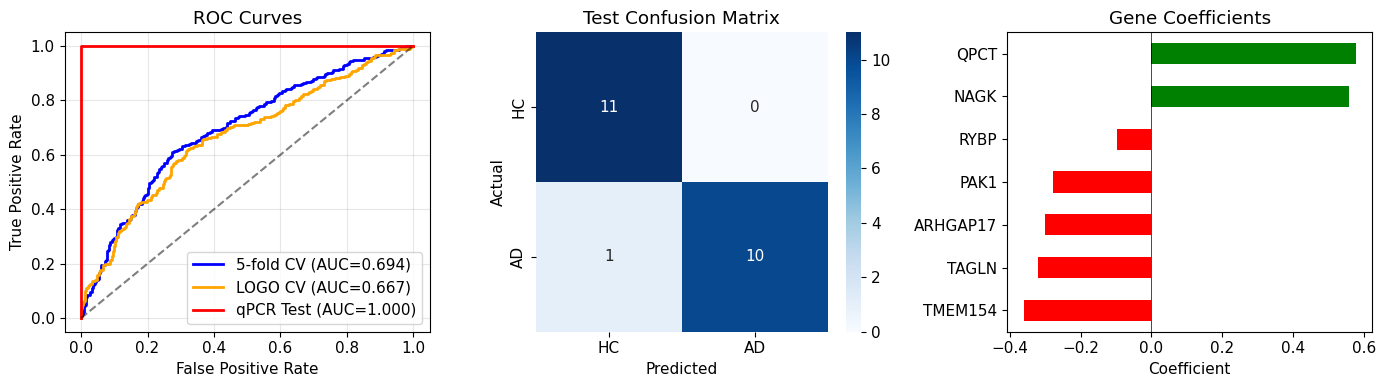

In [9]:
# Cell 6: 可视化
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# ROC 曲线
ax = axes[0]
for name, y_true, y_pred, color in [
    ('5-fold CV', y_train, y_train_pred, 'blue'),
    ('LOGO CV', y_train, y_logo_pred, 'orange'),
    ('qPCR Test', y_test, y_test_pred, 'red')
]:
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    ax.plot(fpr, tpr, color=color, linewidth=2, label=f'{name} (AUC={auc:.3f})')
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

# 混淆矩阵
ax = axes[1]
cm = confusion_matrix(y_test, (y_test_pred >= 0.5).astype(int))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['HC', 'AD'], yticklabels=['HC', 'AD'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Test Confusion Matrix')

# 模型系数
ax = axes[2]
coefs = pd.Series(model.coef_[0], index=OPTIMAL_GENES).sort_values()
colors = ['green' if c > 0 else 'red' for c in coefs]
coefs.plot(kind='barh', ax=ax, color=colors)
ax.axvline(0, color='black', linewidth=0.5)
ax.set_xlabel('Coefficient')
ax.set_title('Gene Coefficients')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'model_results.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# Cell 6.5: Bootstrap 95% CI 计算
print('计算 Bootstrap 95% 置信区间...')

n_bootstrap = 2000
auc_boots, acc_boots, sens_boots, spec_boots = [], [], [], []

for i in range(n_bootstrap):
    idx = np.random.choice(len(y_test), len(y_test), replace=True)
    y_true_boot = y_test[idx]
    y_pred_boot = y_test_pred[idx]
    y_class_boot = (y_pred_boot >= 0.5).astype(int)
    
    if len(np.unique(y_true_boot)) < 2:
        continue
    
    auc_boots.append(roc_auc_score(y_true_boot, y_pred_boot))
    acc_boots.append(accuracy_score(y_true_boot, y_class_boot))
    
    tp = np.sum((y_true_boot == 1) & (y_class_boot == 1))
    fn = np.sum((y_true_boot == 1) & (y_class_boot == 0))
    tn = np.sum((y_true_boot == 0) & (y_class_boot == 0))
    fp = np.sum((y_true_boot == 0) & (y_class_boot == 1))
    
    sens_boots.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    spec_boots.append(tn / (tn + fp) if (tn + fp) > 0 else 0)

auc_boots = np.array(auc_boots)
acc_boots = np.array(acc_boots)
sens_boots = np.array(sens_boots)
spec_boots = np.array(spec_boots)

bootstrap_results = {
    'AUC': {'mean': np.mean(auc_boots), 'ci_low': np.percentile(auc_boots, 2.5), 'ci_high': np.percentile(auc_boots, 97.5)},
    'Accuracy': {'mean': np.mean(acc_boots), 'ci_low': np.percentile(acc_boots, 2.5), 'ci_high': np.percentile(acc_boots, 97.5)},
    'Sensitivity': {'mean': np.mean(sens_boots), 'ci_low': np.percentile(sens_boots, 2.5), 'ci_high': np.percentile(sens_boots, 97.5)},
    'Specificity': {'mean': np.mean(spec_boots), 'ci_low': np.percentile(spec_boots, 2.5), 'ci_high': np.percentile(spec_boots, 97.5)}
}

print(f'\nBootstrap 95% CI 结果 ({len(auc_boots)} iterations):')
for metric, vals in bootstrap_results.items():
    print(f"  {metric}: {vals['mean']:.3f} (95% CI: {vals['ci_low']:.3f} - {vals['ci_high']:.3f})")

计算 Bootstrap 95% 置信区间...

Bootstrap 95% CI 结果 (2000 iterations):
  AUC: 1.000 (95% CI: 1.000 - 1.000)
  Accuracy: 0.955 (95% CI: 0.864 - 1.000)
  Sensitivity: 0.911 (95% CI: 0.714 - 1.000)
  Specificity: 1.000 (95% CI: 1.000 - 1.000)


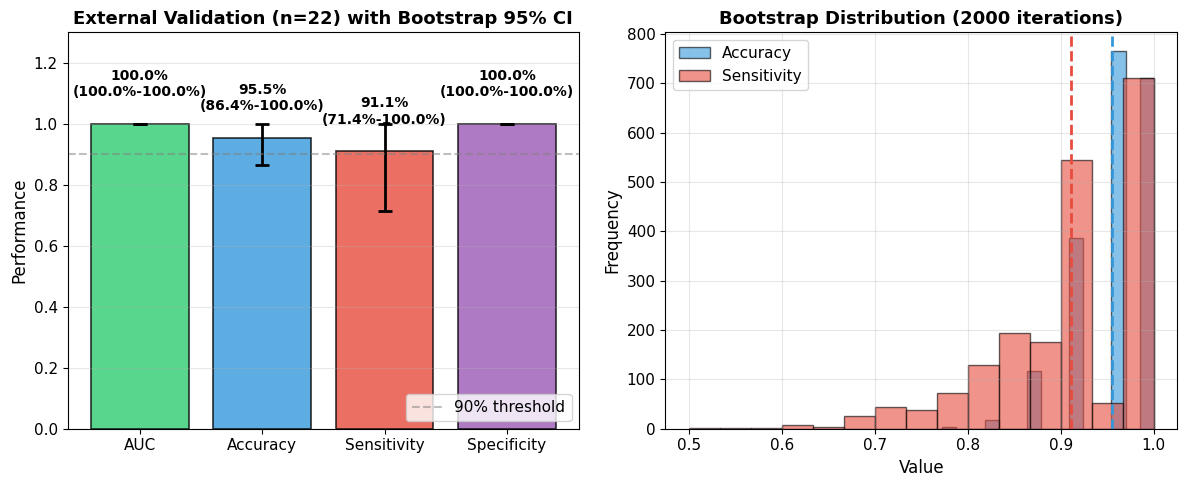

图片已保存: 4_m10_model/bootstrap_ci_results.png


In [11]:
# Cell 6.6: Bootstrap CI 可视化 (论文图表)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 图1: 性能指标柱状图 + 误差棒
ax = axes[0]
metrics = ['AUC', 'Accuracy', 'Sensitivity', 'Specificity']
means = [bootstrap_results[m]['mean'] for m in metrics]
ci_lows = [bootstrap_results[m]['mean'] - bootstrap_results[m]['ci_low'] for m in metrics]
ci_highs = [bootstrap_results[m]['ci_high'] - bootstrap_results[m]['mean'] for m in metrics]

colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']
bars = ax.bar(metrics, means, color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)
ax.errorbar(metrics, means, yerr=[ci_lows, ci_highs], fmt='none', color='black', capsize=5, capthick=2, linewidth=2)

for bar, mean, m in zip(bars, means, metrics):
    ci_l = bootstrap_results[m]['ci_low']
    ci_h = bootstrap_results[m]['ci_high']
    ax.text(bar.get_x() + bar.get_width()/2, mean + 0.08,
            f'{mean:.1%}\n({ci_l:.1%}-{ci_h:.1%})',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_ylim(0, 1.3)
ax.set_ylabel('Performance', fontsize=12)
ax.set_title(f'External Validation (n={len(y_test)}) with Bootstrap 95% CI', fontsize=13, fontweight='bold')
ax.axhline(y=0.9, color='gray', linestyle='--', alpha=0.5, label='90% threshold')
ax.grid(axis='y', alpha=0.3)
ax.legend(loc='lower right')

# 图2: Bootstrap 分布直方图
ax = axes[1]
ax.hist(acc_boots, bins=15, alpha=0.6, color='#3498db', edgecolor='black', label='Accuracy')
ax.hist(sens_boots, bins=15, alpha=0.6, color='#e74c3c', edgecolor='black', label='Sensitivity')
ax.axvline(np.mean(acc_boots), color='#3498db', linestyle='--', linewidth=2)
ax.axvline(np.mean(sens_boots), color='#e74c3c', linestyle='--', linewidth=2)
ax.set_xlabel('Value', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Bootstrap Distribution (2000 iterations)', fontsize=13, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'bootstrap_ci_results.pdf', dpi=300, bbox_inches='tight')
plt.show()
print(f'图片已保存: {OUTPUT_DIR / "bootstrap_ci_results.png"}')

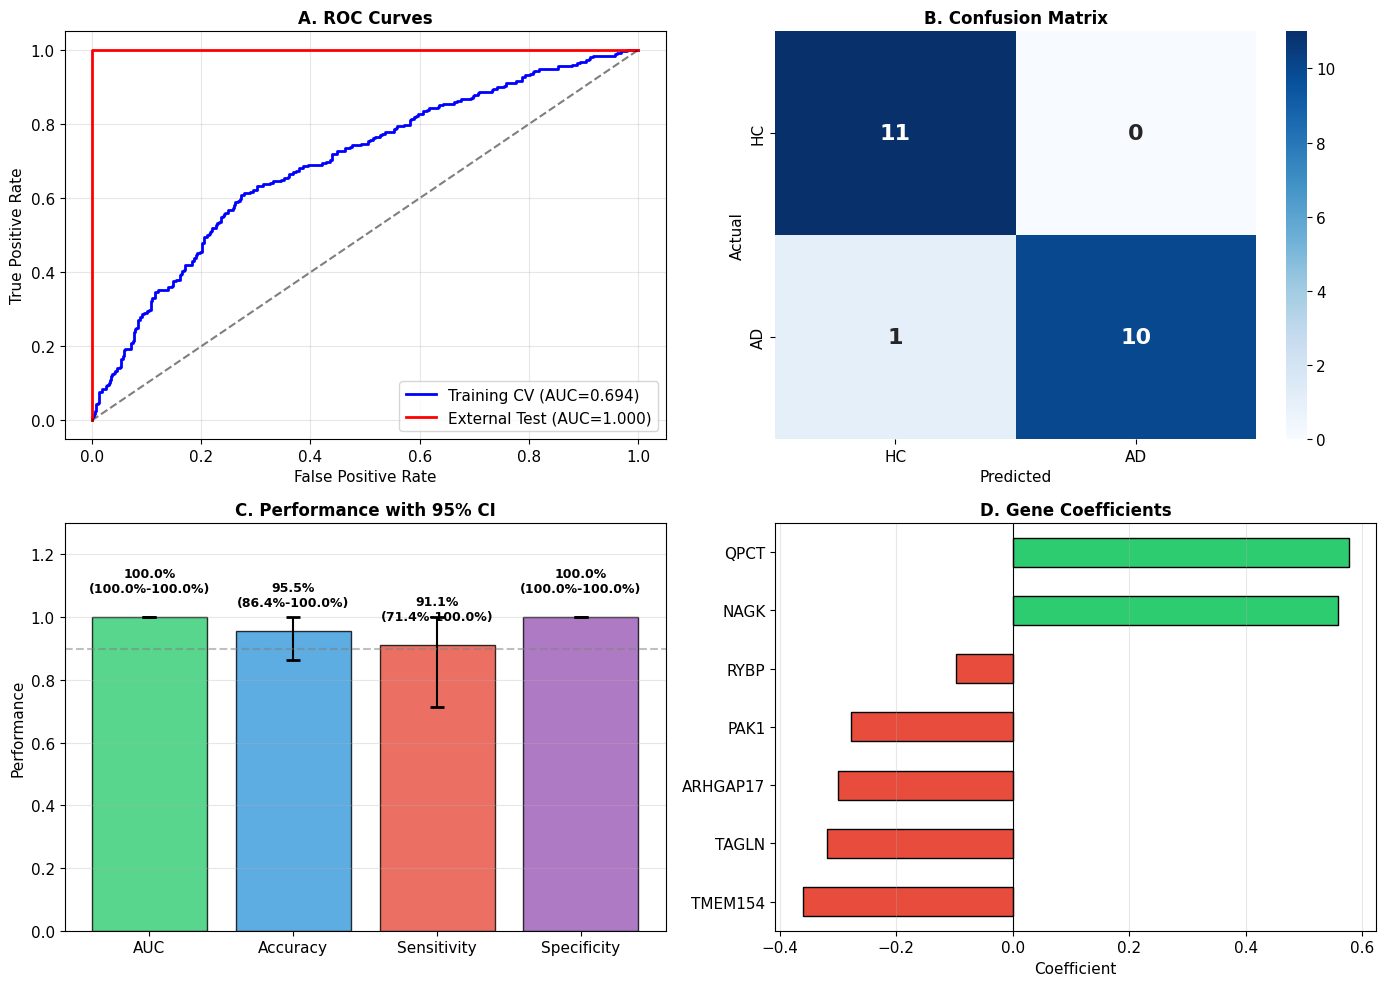

综合图表已保存: 4_m10_model/model_summary_figure.pdf


In [12]:
# Cell 6.7: 综合图表 (论文主图)
fig = plt.figure(figsize=(14, 10))

# A: ROC曲线
ax1 = fig.add_subplot(2, 2, 1)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
ax1.plot(fpr_train, tpr_train, 'b-', linewidth=2, label=f'Training CV (AUC={results["cv_auc"]:.3f})')
ax1.plot(fpr_test, tpr_test, 'r-', linewidth=2, label=f'External Test (AUC={bootstrap_results["AUC"]["mean"]:.3f})')
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_xlabel('False Positive Rate', fontsize=11)
ax1.set_ylabel('True Positive Rate', fontsize=11)
ax1.set_title('A. ROC Curves', fontsize=12, fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(alpha=0.3)

# B: 混淆矩阵
ax2 = fig.add_subplot(2, 2, 2)
cm = confusion_matrix(y_test, (y_test_pred >= 0.5).astype(int))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['HC', 'AD'], yticklabels=['HC', 'AD'],
            annot_kws={'size': 16, 'weight': 'bold'})
ax2.set_xlabel('Predicted', fontsize=11)
ax2.set_ylabel('Actual', fontsize=11)
ax2.set_title('B. Confusion Matrix', fontsize=12, fontweight='bold')

# C: 性能指标 + CI
ax3 = fig.add_subplot(2, 2, 3)
metrics = ['AUC', 'Accuracy', 'Sensitivity', 'Specificity']
means = [bootstrap_results[m]['mean'] for m in metrics]
ci_lows = [bootstrap_results[m]['mean'] - bootstrap_results[m]['ci_low'] for m in metrics]
ci_highs = [bootstrap_results[m]['ci_high'] - bootstrap_results[m]['mean'] for m in metrics]
colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']
bars = ax3.bar(metrics, means, color=colors, alpha=0.8, edgecolor='black')
ax3.errorbar(metrics, means, yerr=[ci_lows, ci_highs], fmt='none', color='black', capsize=5, capthick=2)
for bar, mean, m in zip(bars, means, metrics):
    ci_l = bootstrap_results[m]['ci_low']
    ci_h = bootstrap_results[m]['ci_high']
    ax3.text(bar.get_x() + bar.get_width()/2, mean + 0.08,
            f'{mean:.1%}\n({ci_l:.1%}-{ci_h:.1%})', ha='center', fontsize=9, fontweight='bold')
ax3.set_ylim(0, 1.3)
ax3.set_ylabel('Performance', fontsize=11)
ax3.set_title('C. Performance with 95% CI', fontsize=12, fontweight='bold')
ax3.axhline(y=0.9, color='gray', linestyle='--', alpha=0.5)
ax3.grid(axis='y', alpha=0.3)

# D: 基因系数
ax4 = fig.add_subplot(2, 2, 4)
coefs = pd.Series(model.coef_[0], index=OPTIMAL_GENES).sort_values()
colors = ['#e74c3c' if c < 0 else '#2ecc71' for c in coefs]
coefs.plot(kind='barh', ax=ax4, color=colors, edgecolor='black')
ax4.axvline(0, color='black', linewidth=0.8)
ax4.set_xlabel('Coefficient', fontsize=11)
ax4.set_title('D. Gene Coefficients', fontsize=12, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'model_summary_figure.pdf', dpi=300, bbox_inches='tight')
plt.show()
print(f'综合图表已保存: {OUTPUT_DIR / "model_summary_figure.pdf"}')

In [13]:
# Cell 7: 试剂盒算法
print(f"{'='*60}")
print(f"试剂盒算法 - 模型系数")
print(f"{'='*60}")

coef_df = pd.DataFrame({
    'gene': OPTIMAL_GENES,
    'coefficient': model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print(f"\n基因权重:")
print(coef_df.to_string(index=False))
print(f"\nIntercept: {model.intercept_[0]:.6f}")

print(f"\n预测公式:")
terms = [f"({coef:.4f} × Z_{gene})" for gene, coef in zip(OPTIMAL_GENES, model.coef_[0])]
print(f"score = {model.intercept_[0]:.4f} + {' + '.join(terms)}")
print(f"\nP(AD) = 1 / (1 + exp(-score))")
print(f"判断: P(AD) ≥ 0.5 → AD, P(AD) < 0.5 → HC")

试剂盒算法 - 模型系数

基因权重:
    gene  coefficient
    QPCT     0.577208
    NAGK     0.558859
 TMEM154    -0.360656
   TAGLN    -0.319169
ARHGAP17    -0.299364
    PAK1    -0.276885
    RYBP    -0.097921

Intercept: -0.113152

预测公式:
score = -0.1132 + (0.5589 × Z_NAGK) + (-0.2769 × Z_PAK1) + (0.5772 × Z_QPCT) + (-0.2994 × Z_ARHGAP17) + (-0.0979 × Z_RYBP) + (-0.3192 × Z_TAGLN) + (-0.3607 × Z_TMEM154)

P(AD) = 1 / (1 + exp(-score))
判断: P(AD) ≥ 0.5 → AD, P(AD) < 0.5 → HC


In [14]:
# Cell 8: 保存结果
model_export = {
    'optimal_genes': OPTIMAL_GENES,
    'n_genes': len(OPTIMAL_GENES),
    'coefficients': {gene: float(coef) for gene, coef in zip(OPTIMAL_GENES, model.coef_[0])},
    'intercept': float(model.intercept_[0]),
    'performance': {
        'train_n': int(len(y_train)),
        'cv_auc': float(results['cv_auc']),
        'logo_auc': float(results['logo_auc']),
        'test_n': int(len(y_test)),
        'test_auc': float(results['test_auc']),
        'test_accuracy': float(results['test_acc']),
        'test_sensitivity': float(results['test_sens']),
        'test_specificity': float(results['test_spec'])
    }
}

with open(OUTPUT_DIR / 'kit_model.json', 'w') as f:
    json.dump(model_export, f, indent=2)

print(f"模型已保存: {OUTPUT_DIR / 'kit_model.json'}")

print(f"""
{'='*60}
              最终报告
{'='*60}

【训练数据】
GSE140829 + ADNI: {len(y_train)} 样本 (AD={sum(y_train)}, HC={len(y_train)-sum(y_train)})

【最优基因组合】 ({len(OPTIMAL_GENES)} 基因)
{', '.join(OPTIMAL_GENES)}

【性能指标】
                       AUC
5-fold CV:            {results['cv_auc']:.4f}
Leave-One-Group-Out:  {results['logo_auc']:.4f}
外部测试 (qPCR):       {results['test_auc']:.4f}

【qPCR 测试详情】 (n={len(y_test)})
Accuracy:    {results['test_acc']:.4f}
Sensitivity: {results['test_sens']:.4f}
Specificity: {results['test_spec']:.4f}

{'='*60}
""")

模型已保存: 4_m10_model/kit_model.json

              最终报告

【训练数据】
GSE140829 + ADNI: 757 样本 (AD=248, HC=509)

【最优基因组合】 (7 基因)
NAGK, PAK1, QPCT, ARHGAP17, RYBP, TAGLN, TMEM154

【性能指标】
                       AUC
5-fold CV:            0.6945
Leave-One-Group-Out:  0.6673
外部测试 (qPCR):       1.0000

【qPCR 测试详情】 (n=22)
Accuracy:    0.9545
Sensitivity: 0.9091
Specificity: 1.0000


